# 7 MODELO DE CLASIFICACIÓN

## IMPORTACIÓN DE PAQUETES

In [56]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import label_binarize


## IMPORTAR LOS DATOS

In [3]:
df = pd.read_pickle('../../02_Datos/03_Trabajo/df_tablon.pickle')
df

,stg,scg,str,lpr,peg,level
0,0.00,0.00,0.00,0.00,0.00,3
1,0.08,0.08,0.10,0.24,0.90,0
2,0.06,0.06,0.05,0.25,0.33,1
3,0.10,0.10,0.15,0.65,0.30,2
4,0.08,0.08,0.08,0.98,0.24,1
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,0
254,0.78,0.61,0.71,0.19,0.60,2
255,0.54,0.82,0.71,0.29,0.77,0
256,0.50,0.75,0.81,0.61,0.26,2


### Separar x y 

In [4]:
x = df.drop(columns= 'level').copy()
y = df['level'].copy()

## MODELIZAR

### Reservar Dataset de validación

In [5]:
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size= 0.3)

### Creamos el Pipe y el Diccionario con los algoritmos, Parámetros y valores

In [31]:
pipe = Pipeline([('algoritmo',XGBClassifier())])

grid = [ {'algoritmo': [RandomForestClassifier()],
         'algoritmo__n_jobs': [-1],
         'algoritmo__max_depth': [5,10,15],
         'algoritmo__n_estimators': [50,100,200]},
        
        {'algoritmo': [XGBClassifier()],
         'algoritmo__n_jobs': [-1],
         'algoritmo__learning_rate': [0.01,0.025,0.05,0.1],
         'algoritmo__max_depth': [5,10,20],
         'algoritmo__reg_alpha': [0,0.1,0.5,1],
         'algoritmo__verbosity': [0],#para que no salgan warnings
         'algoritmo__reg_lambda': [0.01,0.1,1],
         'algoritmo__n_estimators': [100,500,1000],
         'algoritmo__multi_class': ['ovr']
         },
        
        {'algoritmo': [HistGradientBoostingClassifier()],
         'algoritmo__learning_rate': [0.01,0.025,0.05,0.1],
         'algoritmo__max_iter': [50,100,200],
         'algoritmo__max_depth': [5,10,20],
         'algoritmo__min_samples_leaf': [500],
         'algoritmo__scoring': ['roc_auc'],
         'algoritmo__l2_regularization': [0,0.25,0.5,0.75,1]
         },
        {'algoritmo': [SVC()],
         'algoritmo__C': [0.1, 1, 10],
         'algoritmo__kernel': ['linear', 'rbf', 'poly'],
         'algoritmo__gamma': [0.1, 0.01, 0.001],
         'algoritmo__class_weight': [None, 'balanced'],
        },
         {'algoritmo': [LogisticRegression()],
          'algoritmo': ['multinomial'],
         'algoritmo__n_jobs': [-1],
         'algoritmo__solver': ['saga'],
         'algoritmo__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algoritmo__C': [0,0.25,0.5,0.75,1]
         }
       ]

### Optimizar los hiper-parámetros

#### Random Search

In [49]:
random_search = RandomizedSearchCV( estimator= pipe,
                                    param_distributions= grid,
                                    n_iter = 5,
                                    cv = 3,
                                    scoring = 'accuracy',
                                    verbose= 0,
                                    n_jobs= -1
                                       )

modelo = random_search.fit(train_x,train_y)                                       

In [50]:
pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo__verbosity,param_algoritmo__reg_lambda,param_algoritmo__reg_alpha,param_algoritmo__n_jobs,param_algoritmo__n_estimators,param_algoritmo__multi_class,...,param_algoritmo__min_samples_leaf,param_algoritmo__max_iter,param_algoritmo__l2_regularization,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.116058,0.004589,0.002669,0.003775,0,1,0.5,-1,100,ovr,...,NaN,NaN,NaN,"{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.933333,0.916667,1.000000,0.950000,0.036004,1
0,0.896619,0.015417,0.004903,0.004857,0,1,0,-1,1000,ovr,...,NaN,NaN,NaN,"{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.916667,0.916667,0.966667,0.933333,0.023570,2
1,0.659713,0.039348,0.001502,0.002124,0,0.01,0.5,-1,500,ovr,...,NaN,NaN,NaN,"{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.900000,0.916667,0.983333,0.933333,0.036004,2
2,0.059032,0.003778,0.008937,0.000687,NaN,NaN,NaN,NaN,NaN,NaN,...,500,50,1,"{'algoritmo__scoring': 'roc_auc', 'algoritmo__...",0.350000,0.350000,0.333333,0.344444,0.007857,4
4,0.052754,0.003279,0.006172,0.002592,NaN,NaN,NaN,NaN,NaN,NaN,...,500,50,0.75,"{'algoritmo__scoring': 'roc_auc', 'algoritmo__...",0.350000,0.350000,0.333333,0.344444,0.007857,4


### Examinar el Mejor modelo

In [51]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.025, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=20,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_class='ovr', n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Importancia de las variables

Text(0, 0.5, 'Features')

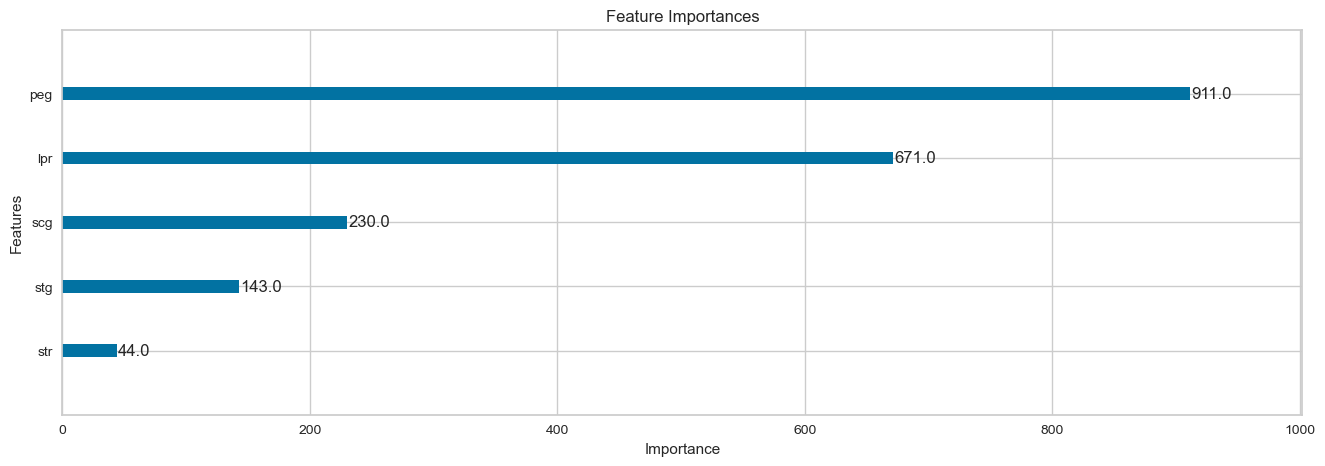

In [52]:
# Get the trained XGBoost model from the pipeline
xgb_model = modelo.best_estimator_.named_steps['algoritmo']

# Get the underlying booster object from the XGBoost model
booster = xgb_model.get_booster()

plt.figure(figsize=(16,5))

# Plot feature importances
xgb.plot_importance(booster, ax=plt.gca())

# Set the plot title and labels

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')


## EVALUAR

### Predecir sobre la validación

In [53]:
pred = modelo.best_estimator_.predict(val_x)

### Evaluar sobre validación

In [54]:
print(classification_report(val_y,pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.84      1.00      0.91        21
           2       0.89      0.89      0.89        28
           3       1.00      0.78      0.88         9

    accuracy                           0.90        78
   macro avg       0.92      0.88      0.89        78
weighted avg       0.90      0.90      0.90        78



### Examinar el Mejor modelo

In [ ]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.025, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=20,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_class='ovr', n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Importancia de las variables

Text(0, 0.5, 'Features')

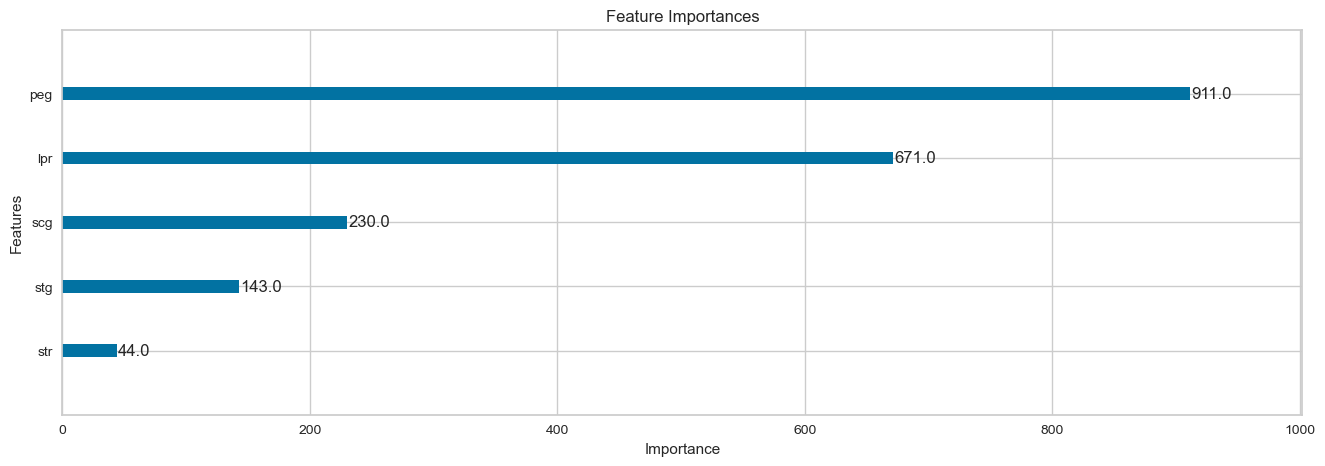

In [ ]:
# Get the trained XGBoost model from the pipeline
xgb_model = modelo.best_estimator_.named_steps['algoritmo']

# Get the underlying booster object from the XGBoost model
booster = xgb_model.get_booster()

plt.figure(figsize=(16,5))

# Plot feature importances
xgb.plot_importance(booster, ax=plt.gca())

# Set the plot title and labels

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')


## REPORTING DEL MODELO

Matrix de Confusión MultiClass

Text(0.5, 1.0, 'Confusion Matrix')

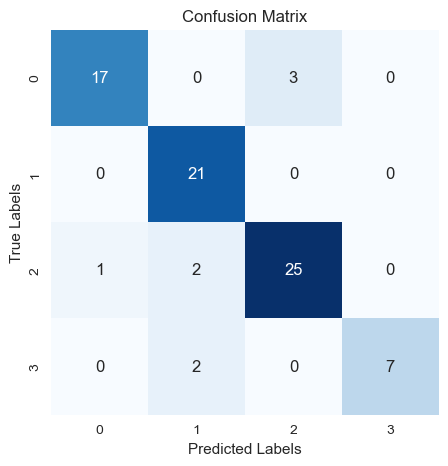

In [70]:



# Calcular la matriz de confusión
cm = confusion_matrix(val_y, pred)


# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Configurar etiquetas y título del gráfico
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")


ROC CHART MULTICLASS

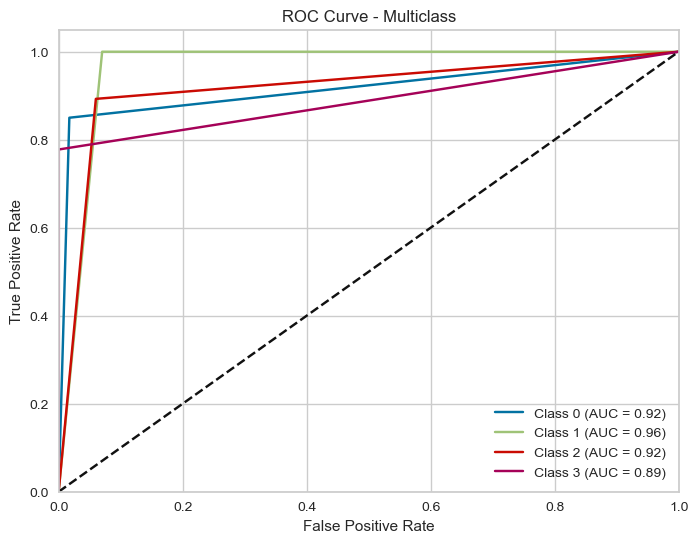

In [71]:
# Binarizar las etiquetas verdaderas y las predicciones para cada clase
n_classes = len(np.unique(val_y))
binarized_val_y = label_binarize(val_y, classes=np.arange(n_classes))
binarized_pred = label_binarize(pred, classes=np.arange(n_classes))

# Calcular la curva ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_val_y[:, i], binarized_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear el gráfico ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Configurar etiquetas y título del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc="lower right")